# Hurricane Damage Detector

# Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

In [2]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
From (redirected): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK&confirm=t&uuid=1d0526f5-8bf1-4510-a09b-4ccc5a1dabe0
To: /kaggle/working/hurricane_detector.zip
100%|██████████████████████████████████████| 39.7M/39.7M [00:00<00:00, 68.1MB/s]


In [3]:
!unzip -q hurricane_detector.zip

In [4]:
ls -l

total 38744
-rw-r--r-- 1 root root 39662128 Apr  5  2024 hurricane_detector.zip
drwxr-xr-x 4 root root     4096 Oct  9 11:59 test_hurricane/
drwxr-xr-x 4 root root     4096 Oct  9 11:59 train_hurricane/


In [5]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.


In [6]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
|-- damage  [655 entries exceeds filelimit, not opening dir]
`-- no_damage  [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
|-- damage  [5895 entries exceeds filelimit, not opening dir]
`-- no_damage  [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


# Import TensorFlow and other libraries

In [8]:
!nvidia-smi

Wed Oct  9 11:59:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             28W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.16.1


# Import Dataset

In [10]:
# Training set

batch_size = 32
img_height = 128
img_width = 128
img_shape = (128, 128, 3)
class_names = ['no_damage', 'damage']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=class_names,
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=class_names,
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
    )

train_ds = train_ds.prefetch(buffer_size=25)
val_ds = val_ds.prefetch(buffer_size=25)     # The prefetch function is used to optimize the data loading process, avoiding idle hardware resources caused by waiting for data while the model is being trained. By loading the next batch of data into memory in advance, the training process is guaranteed to be more efficient.

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


In [11]:
import numpy as np
from collections import Counter

train_labels = []

for images, labels in train_ds:
    train_labels.extend(labels.numpy())  # Convert TensorFlow tensors to NumPy array

train_label_counts = Counter(train_labels)  # Count occurrences of each label
print("Training dataset class balance:", train_label_counts)

val_labels = []

for images, labels in val_ds:
    val_labels.extend(labels.numpy())

val_label_counts = Counter(val_labels)
print("Validation dataset class balance:", val_label_counts)

Training dataset class balance: Counter({0: 569, 1: 518})
Validation dataset class balance: Counter({1: 137, 0: 134})


In [12]:
# Testset

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=class_names,
        seed=42,
        image_size=(img_height, img_width),
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

# Visualize the data

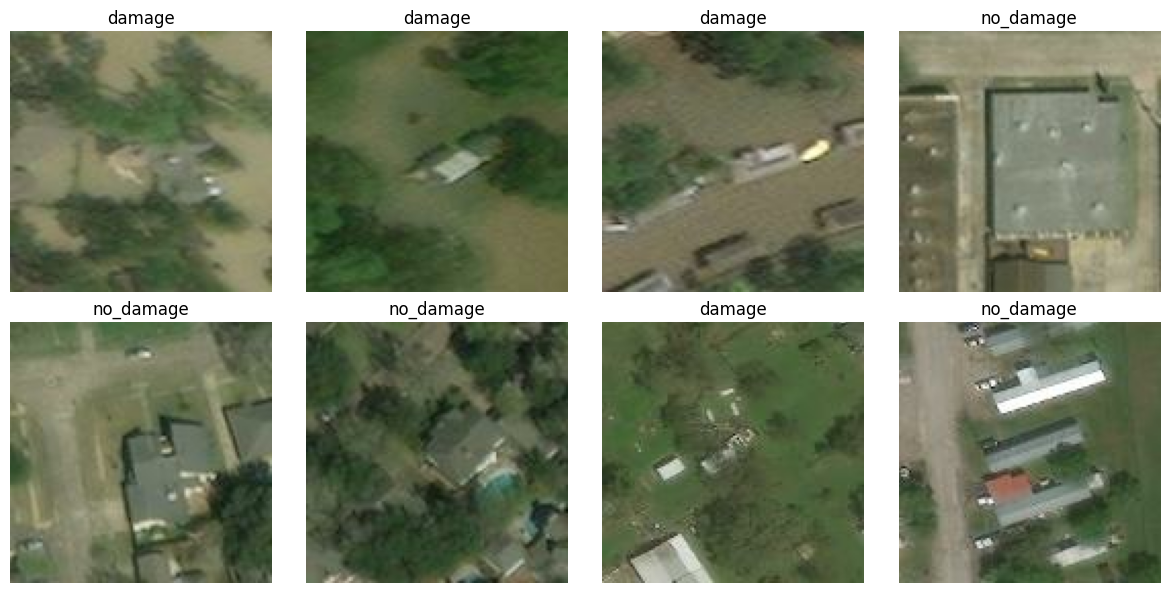

In [13]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.title(class_names[labels[i]])  # 使用类别名称而不是数字
        plt.axis("off")
plt.tight_layout()

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


# Configure the dataset for performance

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(2569).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#  1.Basic Model

## Create the model

In [16]:
from keras import Input, layers, Sequential

model1 = Sequential([

  Input(shape=(img_height, img_width, 3)),

  layers.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),

 layers.Dense(1, activation='sigmoid')
])


## Compile the model

In [17]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,401 (16.09 MB)

 Trainable params: 4,218,401 (16.09 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [19]:
epochs = 10

history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1728475193.182864     117 service.cc:145] XLA service 0x793ca8005aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728475193.182924     117 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/34 ━━━━━━━━━━━━━━━━━━━━ 2:22 4s/step - accuracy: 0.6250 - loss: 0.6877

I0000 00:00:1728475195.749854     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.5110 - loss: 0.9163 - val_accuracy: 0.4945 - val_loss: 0.6985
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5906 - loss: 0.6588 - val_accuracy: 0.8450 - val_loss: 0.5474
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7328 - loss: 0.5438 - val_accuracy: 0.6089 - val_loss: 0.6238
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7674 - loss: 0.5048 - val_accuracy: 0.8561 - val_loss: 0.4088
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8459 - loss: 0.4010 - val_accuracy: 0.7860 - val_loss: 0.4904
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8272 - loss: 0.4135 - val_accuracy: 0.8782 - val_loss: 0.3750
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8775 - loss: 0.3292 - val_accuracy: 0.8598 - val_loss: 0.3949
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8709 - loss: 0.3049 - val_accuracy: 0.8561 - val_loss: 0.4304
E

## Visualize training results

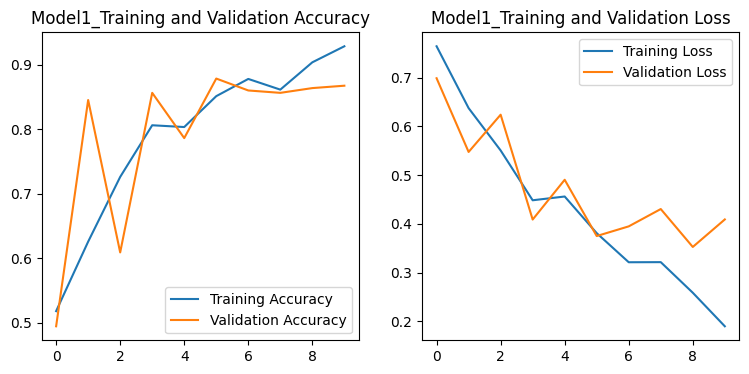

In [20]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model1_Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model1_Training and Validation Loss')

plt.show()

In [21]:
# Validation Loss …… Accuracy
model1_val_loss, model1_val_accuracy = model1.evaluate(val_ds)

print(f"Validation Loss: {model1_val_loss:.2f}")
print(f"Validation Accuracy: {model1_val_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8703 - loss: 0.3420
Validation Loss: 0.41
Validation Accuracy: 0.87


# 2.Augmentation + Dropout Model

## Data augmentation

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=img_shape),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


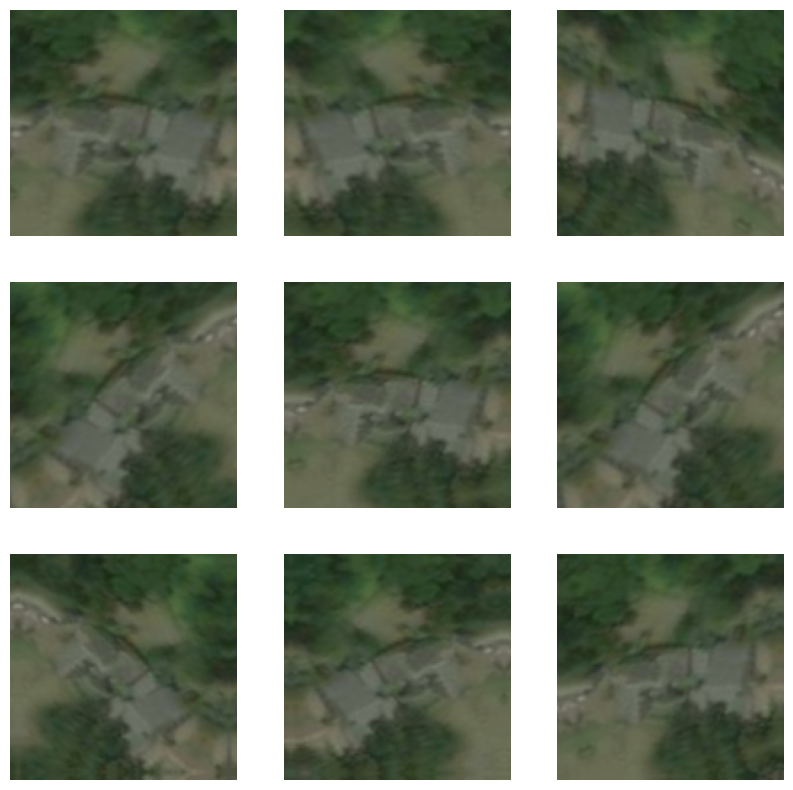

In [23]:
plt.figure(figsize=(10, 10))
# 创建一个大小为 10x10 英寸的绘图画布，用于展示图像。

for images, _ in train_ds.take(1):
# 从训练数据集 `train_ds` 中取出 1 个批次的图像。`train_ds.take(1)` 会返回一个包含图像和标签的批次。
# 这里 `_` 表示忽略标签，因为我们只关心图像进行数据增强展示。

  for i in range(9):
  # 循环 9 次，表示我们要展示 9 张增强后的图像。


    augmented_images = data_augmentation(images)
    # 对每一批次的图像应用数据增强。`data_augmentation(images)` 调用前面定义的数据增强序列。
    # `images` 是一批图像，`augmented_images` 是经过增强处理后的图像。
      # 每次循环中，augmented_images = data_augmentation(images) 生成的新图像集将会有所不同，因为数据增强操作是随机的。

    ax = plt.subplot(3, 3, i + 1)
    # 创建一个 3x3 的子图网格，并设置当前图像显示在第 `i + 1` 个子图中。

    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    # 将增强后的第一张图像（索引为 `0`）显示出来。使用 `numpy().astype("uint8")` 将图像的像素值转换为 8 位无符号整数类型（0-255），这是显示 RGB 图像的常用格式。

    plt.axis("off")
    # 关闭图像的坐标轴，以便更清晰地展示图像内容。

## Create the model

In [24]:
model2 = Sequential([  # 创建一个顺序模型，按顺序添加各层
  data_augmentation,  # 添加数据增强层，用于在训练时对输入图像进行增强处理

  layers.Rescaling(1./255),  # 将像素值从 0-255 归一化到 0-1 范围，以便于模型处理
                              # 这是常见的图像预处理步骤，帮助加快训练过程，提高模型的稳定性

  layers.Conv2D(16, 3, padding='same', activation='relu'),  # 第一层卷积层
  # 使用 16 个 3x3 的卷积核，'same' 填充方式保证输出形状与输入相同
  # 使用 ReLU 激活函数，增加非线性

  layers.MaxPooling2D(),  # 最大池化层，减小特征图的空间维度，保留主要特征
                           # 通常会将特征图的尺寸减少一半，以减少计算量和参数

  layers.Conv2D(32, 3, padding='same', activation='relu'),  # 第二层卷积层
  # 使用 32 个 3x3 的卷积核，继续提取特征
  layers.MaxPooling2D(),  # 另一个最大池化层

  layers.Conv2D(64, 3, padding='same', activation='relu'),  # 第三层卷积层
  # 使用 64 个 3x3 的卷积核，进一步提取特征
  layers.MaxPooling2D(),  # 另一个最大池化层

  layers.Dropout(0.2),  # Dropout 层，随机丢弃 20% 的神经元，防止过拟合
                        # 通过 Dropout，可以让模型学习到更加鲁棒的特征

  layers.Flatten(),  # 将 3D 特征图展平成 1D 向量，准备传递给全连接层

  layers.Dense(256, activation='relu'),

  layers.Dense(1, activation='sigmoid')
])

## Compile the model

In [25]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [27]:
epochs = 15

history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2024-10-09 12:00:05.854040: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4841 - loss: 0.7020 - val_accuracy: 0.7306 - val_loss: 0.6486
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6354 - loss: 0.6261 - val_accuracy: 0.5166 - val_loss: 1.0560
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6919 - loss: 0.6046 - val_accuracy: 0.8376 - val_loss: 0.4981
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7890 - loss: 0.4832 - val_accuracy: 0.8155 - val_loss: 0.5366
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8108 - loss: 0.4444 - val_accuracy: 0.8930 - val_loss: 0.3353
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8133 - loss: 0.4046 - val_accuracy: 0.8266 - val_loss: 0.4187
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8929 - loss: 0.2775 - val_accuracy: 0.9151 - val_loss: 0.2380
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8880 - loss: 0.2815 - val_accuracy: 0.9041 - val_loss: 0.

## Visualize training results

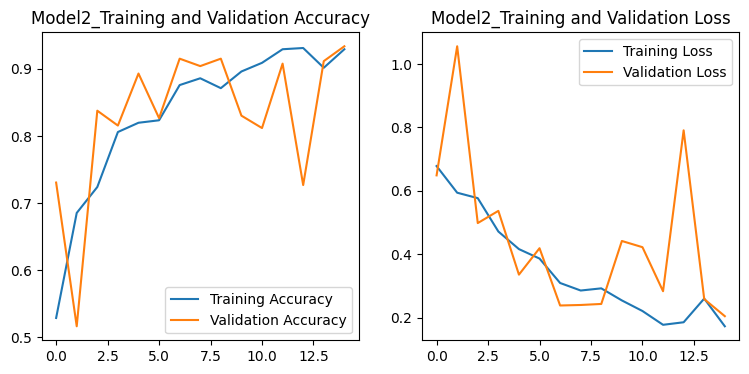

In [28]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model2_Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model2_Training and Validation Loss')

plt.show()

In [29]:
# Validation Loss …… Accuracy
model2_val_loss, model2_val_accuracy = model2.evaluate(val_ds)

print(f"Validation Loss: {model2_val_loss:.2f}")
print(f"Validation Accuracy: {model2_val_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9511 - loss: 0.1812
Validation Loss: 0.20
Validation Accuracy: 0.93


# 3.ResNet50 Model

## Create the base model from the pre-trained convnets

In [30]:
base_model = tf.keras.applications.ResNet50(input_shape=img_shape,
                                            include_top=False,
                                            weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [32]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# 4x4 and 2048 from Basic Model from ResNet50

(32, 4, 4, 2048)


## Freeze the convolutional base

In [33]:
base_model.trainable = False

In [34]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

input_layer_3 -> False
conv1_pad -> False
conv1_conv -> False
conv1_bn -> False
conv1_relu -> False
pool1_pad -> False
pool1_pool -> False
conv2_block1_1_conv -> False
conv2_block1_1_bn -> False
conv2_block1_1_relu -> False
conv2_block1_2_conv -> False
conv2_block1_2_bn -> False
conv2_block1_2_relu -> False
conv2_block1_0_conv -> False
conv2_block1_3_conv -> False
conv2_block1_0_bn -> False
conv2_block1_3_bn -> False
conv2_block1_add -> False
conv2_block1_out -> False
conv2_block2_1_conv -> False
conv2_block2_1_bn -> False
conv2_block2_1_relu -> False
conv2_block2_2_conv -> False
conv2_block2_2_bn -> False
conv2_block2_2_relu -> False
conv2_block2_3_conv -> False
conv2_block2_3_bn -> False
conv2_block2_add -> False
conv2_block2_out -> False
conv2_block3_1_conv -> False
conv2_block3_1_bn -> False
conv2_block3_1_relu -> False
conv2_block3_2_conv -> False
conv2_block3_2_bn -> False
conv2_block3_2_relu -> False
conv2_block3_3_conv -> False
conv2_block3_3_bn -> False
conv2_block3_add -> Fal

## Add a classification head with BatchNormalization layers

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [36]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
dense_output = dense_layer(feature_batch_average)
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(dense_output)
print(prediction_batch.shape)

(32, 5)


## Create the Model with Keras API

In [37]:
inputs = tf.keras.Input(shape=img_shape)

aug_img = data_augmentation(inputs)

pre_img = tf.keras.applications.resnet.preprocess_input(aug_img)

# important: training=False if you dont want to finetune batchnorm layers
res_model_fm = base_model(pre_img, training=False)

feature_vecs = tf.keras.layers.GlobalAveragePooling2D()(res_model_fm)
# 将模型输出的特征图通过全局平均池化层进行处理，得到每个通道的平均值。
# 输出的 feature_vecs 是一个形状为 (batch_size, channels) 的张量，表示每个样本的特征向量。

dense1 = tf.keras.layers.Dense(256)(feature_vecs)
# 创建一个全连接层，具有 256 个神经元，将特征向量（feature_vecs）传递给该层。
# 该层用于对提取的特征进行进一步的非线性变换。

drop1 = tf.keras.layers.Dropout(0.2)(dense1)
# 添加一个 Dropout 层，以减少过拟合的风险。
# 在训练期间，Dropout 将随机丢弃 20% 的神经元，以提高模型的泛化能力。

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(drop1)
# 创建最后的全连接层，具有 5 个神经元，并使用 softmax 激活函数。
# 该层将输出每个类别的概率，适用于多分类任务（如 5 种花）。

model3 = tf.keras.Model(inputs, outputs)
# 使用 Keras 功能 API 创建最终模型，将输入层和输出层连接起来。
# 此模型现在可以用于训练和推理。

## Compile the model

In [38]:
base_learning_rate = 0.0001
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [39]:
model3.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128, 128)  │          0 │ sequential_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128, 128)  │          0 │ sequential_1[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 128, 128)  │          0 │ sequential_1[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 128, 128,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [40]:
for layer in model3.layers:
    print(layer.name, '->', layer.trainable)

input_layer_4 -> True
sequential_1 -> True
resnet50 -> False
global_average_pooling2d_1 -> True
dense_6 -> True
dropout_1 -> True
dense_7 -> True


## Train the model

In [41]:
initial_epochs = 10

history3 = model3.fit(train_ds,
                   epochs=initial_epochs,
                   validation_data=val_ds)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.7414 - loss: 0.5578 - val_accuracy: 0.8967 - val_loss: 0.2553
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8941 - loss: 0.2526 - val_accuracy: 0.9188 - val_loss: 0.2301
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9255 - loss: 0.1953 - val_accuracy: 0.9299 - val_loss: 0.1947
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9215 - loss: 0.2074 - val_accuracy: 0.9299 - val_loss: 0.1835
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9362 - loss: 0.1835 - val_accuracy: 0.9373 - val_loss: 0.1742
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9563 - loss: 0.1308 - val_accuracy: 0.9446 - val_loss: 0.1892
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9598 - loss: 0.1131 - val_accuracy: 0.9446 - val_loss: 0.1724
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9628 - loss: 0.0980 - val_accuracy: 0.9483 -

## Visualize training results

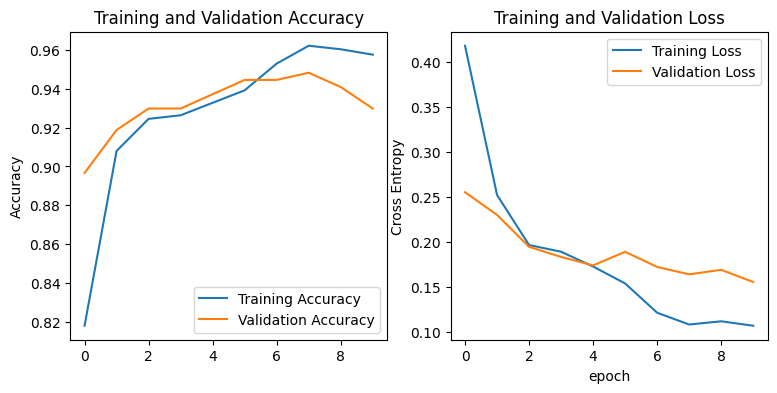

In [42]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
# Validation Loss …… Accuracy
model3_val_loss, model3_val_accuracy = model3.evaluate(val_ds)

print(f"Validation Loss: {model3_val_loss:.2f}")
print(f"Validation Accuracy: {model3_val_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9427 - loss: 0.1205
Validation Loss: 0.16
Validation Accuracy: 0.93


# 4.ResNet50 Model and Fine tuning

## Refreeze the convolutional base

In [44]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))  # 打印基础模型中的层数

Number of layers in the base model:  175


In [45]:
for layer in base_model.layers:
  print(layer.name, '->', layer.trainable)

input_layer_3 -> True
conv1_pad -> True
conv1_conv -> True
conv1_bn -> True
conv1_relu -> True
pool1_pad -> True
pool1_pool -> True
conv2_block1_1_conv -> True
conv2_block1_1_bn -> True
conv2_block1_1_relu -> True
conv2_block1_2_conv -> True
conv2_block1_2_bn -> True
conv2_block1_2_relu -> True
conv2_block1_0_conv -> True
conv2_block1_3_conv -> True
conv2_block1_0_bn -> True
conv2_block1_3_bn -> True
conv2_block1_add -> True
conv2_block1_out -> True
conv2_block2_1_conv -> True
conv2_block2_1_bn -> True
conv2_block2_1_relu -> True
conv2_block2_2_conv -> True
conv2_block2_2_bn -> True
conv2_block2_2_relu -> True
conv2_block2_3_conv -> True
conv2_block2_3_bn -> True
conv2_block2_add -> True
conv2_block2_out -> True
conv2_block3_1_conv -> True
conv2_block3_1_bn -> True
conv2_block3_1_relu -> True
conv2_block3_2_conv -> True
conv2_block3_2_bn -> True
conv2_block3_2_relu -> True
conv2_block3_3_conv -> True
conv2_block3_3_bn -> True
conv2_block3_add -> True
conv2_block3_out -> True
conv3_bloc

In [46]:
# Fine-tune from this layer onwards
fine_tune_at = 80  # 设置微调的起始层为基础模型的第 100 层

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [47]:
for index, layer in enumerate(base_model.layers):
  print(index, ':', layer.name, '->', layer.trainable)

0 : input_layer_3 -> False
1 : conv1_pad -> False
2 : conv1_conv -> False
3 : conv1_bn -> False
4 : conv1_relu -> False
5 : pool1_pad -> False
6 : pool1_pool -> False
7 : conv2_block1_1_conv -> False
8 : conv2_block1_1_bn -> False
9 : conv2_block1_1_relu -> False
10 : conv2_block1_2_conv -> False
11 : conv2_block1_2_bn -> False
12 : conv2_block1_2_relu -> False
13 : conv2_block1_0_conv -> False
14 : conv2_block1_3_conv -> False
15 : conv2_block1_0_bn -> False
16 : conv2_block1_3_bn -> False
17 : conv2_block1_add -> False
18 : conv2_block1_out -> False
19 : conv2_block2_1_conv -> False
20 : conv2_block2_1_bn -> False
21 : conv2_block2_1_relu -> False
22 : conv2_block2_2_conv -> False
23 : conv2_block2_2_bn -> False
24 : conv2_block2_2_relu -> False
25 : conv2_block2_3_conv -> False
26 : conv2_block2_3_bn -> False
27 : conv2_block2_add -> False
28 : conv2_block2_out -> False
29 : conv2_block3_1_conv -> False
30 : conv2_block3_1_bn -> False
31 : conv2_block3_1_relu -> False
32 : conv2_blo

## Compile the model

In [48]:
learning_rate = base_learning_rate/10
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [49]:
for layer in model3.layers:
    print(layer.name, '->', layer.trainable)

input_layer_4 -> True
sequential_1 -> True
resnet50 -> True
global_average_pooling2d_1 -> True
dense_6 -> True
dropout_1 -> True
dense_7 -> True


In [50]:
fine_tune_epochs = 10

total_epochs = initial_epochs + fine_tune_epochs

history4 = model3.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history3.epoch[-1],
    validation_data=val_ds
)

Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.8908 - loss: 0.2442 - val_accuracy: 0.9557 - val_loss: 0.1558
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9488 - loss: 0.1368 - val_accuracy: 0.9483 - val_loss: 0.1630
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9422 - loss: 0.1237 - val_accuracy: 0.9594 - val_loss: 0.1718
Epoch 13/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9542 - loss: 0.1024 - val_accuracy: 0.9594 - val_loss: 0.1710
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9682 - loss: 0.0726 - val_accuracy: 0.9594 - val_loss: 0.1502
Epoch 15/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9747 - loss: 0.0770 - val_accuracy: 0.9520 - val_loss: 0.1455
Epoch 16/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9818 - loss: 0.0513 - val_accuracy: 0.9557 - val_loss: 0.1459
Epoch 17/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9651 - loss: 0.1039 - val_accuracy: 

## Visualize training results

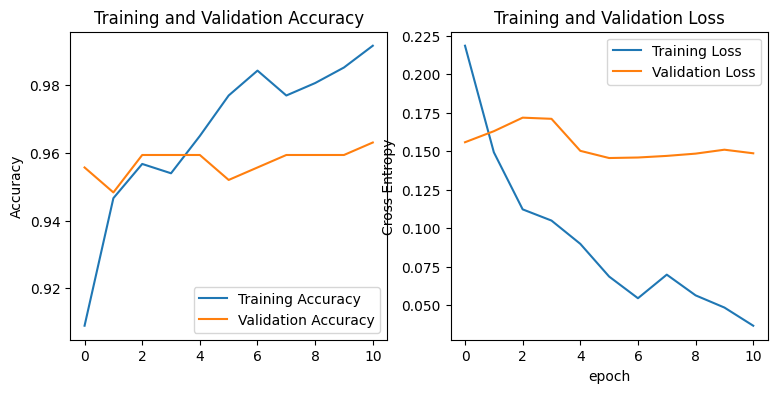

In [51]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
# Validation Loss …… Accuracy
mode3_tune_val_loss, model3_tune_val_accuracy = model3.evaluate(val_ds)

print(f"Validation Loss: {mode3_tune_val_loss:.2f}")
print(f"Validation Accuracy: {model3_tune_val_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9765 - loss: 0.0991
Validation Loss: 0.15
Validation Accuracy: 0.96


# Result

## Model 1

In [53]:
test_labels, predictions = eval_model_on_test(model1)
from sklearn.metrics import classification_report

predictions_binary = np.where(predictions > 0.5, 1, 0)

print(classification_report(y_true=test_labels,
                            y_pred=predictions_binary,
                            target_names=class_names
))

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


Predicting on Test Data:   1%|          | 1/96 [00:00<00:41,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:23,  4.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   3%|▎         | 3/96 [00:00<00:17,  5.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   4%|▍         | 4/96 [00:00<00:14,  6.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   5%|▌         | 5/96 [00:00<00:13,  6.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   6%|▋         | 6/96 [00:01<00:12,  7.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   7%|▋         | 7/96 [00:01<00:11,  7.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   8%|▊         | 8/96 [00:01<00:10,  8.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   9%|▉         | 9/96 [00:01<00:10,  8.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  10%|█         | 10/96 [00:01<00:10,  8.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  11%|█▏        | 11/96 [00:01<00:10,  8.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  12%|█▎        | 12/96 [00:01<00:09,  8.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  14%|█▎        | 13/96 [00:01<00:09,  8.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  15%|█▍        | 14/96 [00:01<00:09,  8.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  16%|█▌        | 15/96 [00:02<00:09,  8.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  17%|█▋        | 16/96 [00:02<00:09,  8.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  18%|█▊        | 17/96 [00:02<00:09,  8.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  19%|█▉        | 18/96 [00:02<00:09,  8.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  20%|█▉        | 19/96 [00:02<00:08,  8.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  21%|██        | 20/96 [00:02<00:08,  8.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  22%|██▏       | 21/96 [00:02<00:08,  8.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  23%|██▎       | 22/96 [00:02<00:08,  8.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  24%|██▍       | 23/96 [00:02<00:08,  8.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  25%|██▌       | 24/96 [00:03<00:08,  8.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  26%|██▌       | 25/96 [00:03<00:08,  8.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  27%|██▋       | 26/96 [00:03<00:08,  8.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  28%|██▊       | 27/96 [00:03<00:07,  8.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  29%|██▉       | 28/96 [00:03<00:07,  8.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  30%|███       | 29/96 [00:03<00:07,  8.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  31%|███▏      | 30/96 [00:03<00:07,  8.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  32%|███▏      | 31/96 [00:03<00:07,  8.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  33%|███▎      | 32/96 [00:04<00:07,  8.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  34%|███▍      | 33/96 [00:04<00:07,  8.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  35%|███▌      | 34/96 [00:04<00:07,  8.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  36%|███▋      | 35/96 [00:04<00:07,  8.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  38%|███▊      | 36/96 [00:04<00:06,  8.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  39%|███▊      | 37/96 [00:04<00:06,  8.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  40%|███▉      | 38/96 [00:04<00:06,  8.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  41%|████      | 39/96 [00:04<00:06,  8.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  42%|████▏     | 40/96 [00:04<00:06,  8.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  43%|████▎     | 41/96 [00:05<00:06,  8.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  44%|████▍     | 42/96 [00:05<00:06,  8.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  45%|████▍     | 43/96 [00:05<00:06,  8.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  46%|████▌     | 44/96 [00:05<00:05,  8.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  47%|████▋     | 45/96 [00:05<00:05,  8.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  48%|████▊     | 46/96 [00:05<00:05,  8.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  49%|████▉     | 47/96 [00:05<00:05,  8.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  50%|█████     | 48/96 [00:05<00:05,  8.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  51%|█████     | 49/96 [00:05<00:05,  8.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  52%|█████▏    | 50/96 [00:06<00:05,  8.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  53%|█████▎    | 51/96 [00:06<00:05,  8.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  54%|█████▍    | 52/96 [00:06<00:05,  8.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  55%|█████▌    | 53/96 [00:06<00:04,  8.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  56%|█████▋    | 54/96 [00:06<00:04,  8.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  57%|█████▋    | 55/96 [00:06<00:04,  8.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  58%|█████▊    | 56/96 [00:06<00:04,  8.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  59%|█████▉    | 57/96 [00:06<00:04,  8.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  60%|██████    | 58/96 [00:07<00:04,  8.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  61%|██████▏   | 59/96 [00:07<00:04,  8.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  62%|██████▎   | 60/96 [00:07<00:04,  8.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  64%|██████▎   | 61/96 [00:07<00:04,  8.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  65%|██████▍   | 62/96 [00:07<00:03,  8.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  66%|██████▌   | 63/96 [00:07<00:03,  8.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  67%|██████▋   | 64/96 [00:07<00:03,  8.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  68%|██████▊   | 65/96 [00:07<00:03,  8.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  69%|██████▉   | 66/96 [00:07<00:03,  8.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  70%|██████▉   | 67/96 [00:08<00:03,  8.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  71%|███████   | 68/96 [00:08<00:03,  8.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  72%|███████▏  | 69/96 [00:08<00:03,  8.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  73%|███████▎  | 70/96 [00:08<00:02,  8.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  74%|███████▍  | 71/96 [00:08<00:02,  8.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  75%|███████▌  | 72/96 [00:08<00:02,  8.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  76%|███████▌  | 73/96 [00:08<00:02,  8.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  77%|███████▋  | 74/96 [00:08<00:02,  8.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  78%|███████▊  | 75/96 [00:09<00:02,  8.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  79%|███████▉  | 76/96 [00:09<00:02,  8.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  80%|████████  | 77/96 [00:09<00:02,  8.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  81%|████████▏ | 78/96 [00:09<00:02,  8.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  82%|████████▏ | 79/96 [00:09<00:01,  8.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  83%|████████▎ | 80/96 [00:09<00:01,  8.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  84%|████████▍ | 81/96 [00:09<00:01,  8.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  85%|████████▌ | 82/96 [00:09<00:01,  8.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  86%|████████▋ | 83/96 [00:09<00:01,  8.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  88%|████████▊ | 84/96 [00:10<00:01,  8.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  89%|████████▊ | 85/96 [00:10<00:01,  8.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  90%|████████▉ | 86/96 [00:10<00:01,  8.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  91%|█████████ | 87/96 [00:10<00:01,  8.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  92%|█████████▏| 88/96 [00:10<00:00,  8.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  93%|█████████▎| 89/96 [00:10<00:00,  8.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  94%|█████████▍| 90/96 [00:10<00:00,  8.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  95%|█████████▍| 91/96 [00:10<00:00,  8.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  96%|█████████▌| 92/96 [00:10<00:00,  8.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  97%|█████████▋| 93/96 [00:11<00:00,  8.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  98%|█████████▊| 94/96 [00:11<00:00,  8.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  99%|█████████▉| 95/96 [00:11<00:00,  8.91it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:11<00:00,  8.13it/s]

              precision    recall  f1-score   support

   no_damage       0.93      0.74      0.82      6333
      damage       0.77      0.94      0.85      5895

    accuracy                           0.84     12228
   macro avg       0.85      0.84      0.84     12228
weighted avg       0.85      0.84      0.83     12228



## Model  2

In [54]:
test_labels, predictions = eval_model_on_test(model2)
from sklearn.metrics import classification_report

predictions_binary = np.where(predictions > 0.5, 1, 0)

print(classification_report(y_true=test_labels,
                            y_pred=predictions_binary,
                            target_names=class_names
))

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   1%|          | 1/96 [00:00<00:21,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   2%|▏         | 2/96 [00:00<00:15,  6.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   3%|▎         | 3/96 [00:00<00:13,  6.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   4%|▍         | 4/96 [00:00<00:12,  7.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   5%|▌         | 5/96 [00:00<00:11,  7.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   6%|▋         | 6/96 [00:00<00:11,  8.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   7%|▋         | 7/96 [00:00<00:10,  8.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   8%|▊         | 8/96 [00:01<00:10,  8.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:   9%|▉         | 9/96 [00:01<00:10,  8.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  10%|█         | 10/96 [00:01<00:10,  8.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  11%|█▏        | 11/96 [00:01<00:10,  8.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  12%|█▎        | 12/96 [00:01<00:09,  8.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  14%|█▎        | 13/96 [00:01<00:09,  8.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  15%|█▍        | 14/96 [00:01<00:09,  8.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  16%|█▌        | 15/96 [00:01<00:09,  8.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  17%|█▋        | 16/96 [00:01<00:09,  8.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  18%|█▊        | 17/96 [00:02<00:09,  8.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  19%|█▉        | 18/96 [00:02<00:09,  8.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  20%|█▉        | 19/96 [00:02<00:08,  8.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  21%|██        | 20/96 [00:02<00:08,  8.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  22%|██▏       | 21/96 [00:02<00:08,  8.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  23%|██▎       | 22/96 [00:02<00:08,  8.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  24%|██▍       | 23/96 [00:02<00:08,  8.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  25%|██▌       | 24/96 [00:02<00:08,  8.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  26%|██▌       | 25/96 [00:03<00:08,  8.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  27%|██▋       | 26/96 [00:03<00:08,  8.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  28%|██▊       | 27/96 [00:03<00:08,  8.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  29%|██▉       | 28/96 [00:03<00:07,  8.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  30%|███       | 29/96 [00:03<00:07,  8.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  31%|███▏      | 30/96 [00:03<00:07,  8.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  32%|███▏      | 31/96 [00:03<00:07,  8.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  33%|███▎      | 32/96 [00:03<00:07,  8.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  34%|███▍      | 33/96 [00:03<00:07,  8.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  35%|███▌      | 34/96 [00:04<00:07,  8.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  36%|███▋      | 35/96 [00:04<00:07,  8.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  38%|███▊      | 36/96 [00:04<00:07,  8.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  39%|███▊      | 37/96 [00:04<00:07,  8.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  40%|███▉      | 38/96 [00:04<00:06,  8.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  41%|████      | 39/96 [00:04<00:06,  8.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  42%|████▏     | 40/96 [00:04<00:06,  8.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  43%|████▎     | 41/96 [00:04<00:06,  8.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  44%|████▍     | 42/96 [00:05<00:06,  8.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  45%|████▍     | 43/96 [00:05<00:06,  8.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  46%|████▌     | 44/96 [00:05<00:06,  8.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  47%|████▋     | 45/96 [00:05<00:05,  8.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  48%|████▊     | 46/96 [00:05<00:05,  8.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  49%|████▉     | 47/96 [00:05<00:06,  8.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  50%|█████     | 48/96 [00:05<00:06,  7.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  51%|█████     | 49/96 [00:05<00:06,  7.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  52%|█████▏    | 50/96 [00:06<00:05,  7.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  53%|█████▎    | 51/96 [00:06<00:05,  7.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  54%|█████▍    | 52/96 [00:06<00:05,  8.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  55%|█████▌    | 53/96 [00:06<00:05,  8.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  56%|█████▋    | 54/96 [00:06<00:05,  8.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  57%|█████▋    | 55/96 [00:06<00:04,  8.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  58%|█████▊    | 56/96 [00:06<00:04,  8.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  59%|█████▉    | 57/96 [00:06<00:04,  8.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  60%|██████    | 58/96 [00:06<00:04,  8.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  61%|██████▏   | 59/96 [00:07<00:04,  8.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  62%|██████▎   | 60/96 [00:07<00:04,  8.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  64%|██████▎   | 61/96 [00:07<00:04,  8.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  65%|██████▍   | 62/96 [00:07<00:04,  8.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  66%|██████▌   | 63/96 [00:07<00:03,  8.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  67%|██████▋   | 64/96 [00:07<00:03,  8.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  68%|██████▊   | 65/96 [00:07<00:03,  8.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  69%|██████▉   | 66/96 [00:07<00:03,  8.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  70%|██████▉   | 67/96 [00:08<00:03,  8.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  71%|███████   | 68/96 [00:08<00:03,  8.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  72%|███████▏  | 69/96 [00:08<00:03,  8.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  73%|███████▎  | 70/96 [00:08<00:03,  8.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  74%|███████▍  | 71/96 [00:08<00:02,  8.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  75%|███████▌  | 72/96 [00:08<00:02,  8.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  76%|███████▌  | 73/96 [00:08<00:02,  8.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  77%|███████▋  | 74/96 [00:08<00:02,  8.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  78%|███████▊  | 75/96 [00:08<00:02,  8.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  79%|███████▉  | 76/96 [00:09<00:02,  8.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  80%|████████  | 77/96 [00:09<00:02,  8.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  81%|████████▏ | 78/96 [00:09<00:02,  8.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  82%|████████▏ | 79/96 [00:09<00:01,  8.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  83%|████████▎ | 80/96 [00:09<00:01,  8.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  84%|████████▍ | 81/96 [00:09<00:01,  8.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  85%|████████▌ | 82/96 [00:09<00:01,  8.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  86%|████████▋ | 83/96 [00:09<00:01,  8.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  88%|████████▊ | 84/96 [00:10<00:01,  8.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  89%|████████▊ | 85/96 [00:10<00:01,  8.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  90%|████████▉ | 86/96 [00:10<00:01,  8.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  91%|█████████ | 87/96 [00:10<00:01,  8.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  92%|█████████▏| 88/96 [00:10<00:00,  8.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  93%|█████████▎| 89/96 [00:10<00:00,  8.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Predicting on Test Data:  94%|█████████▍| 90/96 [00:10<00:00,  7.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  95%|█████████▍| 91/96 [00:10<00:00,  7.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  96%|█████████▌| 92/96 [00:11<00:00,  7.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Predicting on Test Data:  97%|█████████▋| 93/96 [00:11<00:00,  7.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Predicting on Test Data:  98%|█████████▊| 94/96 [00:11<00:00,  7.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Predicting on Test Data:  99%|█████████▉| 95/96 [00:11<00:00,  7.61it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:11<00:00,  8.20it/s]

              precision    recall  f1-score   support

   no_damage       0.93      0.92      0.92      6333
      damage       0.91      0.93      0.92      5895

    accuracy                           0.92     12228
   macro avg       0.92      0.92      0.92     12228
weighted avg       0.92      0.92      0.92     12228



## Model 3

In [55]:
test_labels, predictions = eval_model_on_test(model3)
from sklearn.metrics import classification_report

predictions_binary = np.where(predictions > 0.5, 1, 0)

print(classification_report(y_true=test_labels,
                            y_pred=predictions_binary,
                            target_names=class_names
))

Found 12228 files belonging to 2 classes.


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


Predicting on Test Data:   1%|          | 1/96 [00:02<03:13,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<01:30,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:02<00:57,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:02<00:42,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:02<00:33,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:03<00:28,  3.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:03<00:24,  3.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:03<00:22,  3.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:03<00:20,  4.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:03<00:19,  4.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:04<00:19,  4.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:04<00:18,  4.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:04<00:17,  4.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:04<00:17,  4.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:04<00:17,  4.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:05<00:16,  4.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:05<00:16,  4.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:05<00:16,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:05<00:15,  4.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:05<00:15,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:06<00:15,  4.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:06<00:15,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:06<00:15,  4.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:06<00:15,  4.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:07<00:14,  4.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:07<00:14,  4.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:07<00:14,  4.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:07<00:14,  4.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:07<00:14,  4.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:08<00:13,  4.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:08<00:13,  4.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:08<00:13,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:08<00:13,  4.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:08<00:13,  4.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:09<00:12,  4.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:09<00:12,  4.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:09<00:12,  4.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:09<00:12,  4.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:09<00:11,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:10<00:11,  4.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:10<00:11,  4.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:10<00:11,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:10<00:11,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:11<00:10,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:11<00:10,  4.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:11<00:10,  4.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:11<00:10,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:11<00:09,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:12<00:09,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:12<00:09,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:12<00:09,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:12<00:09,  4.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:12<00:08,  4.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:13<00:08,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:13<00:08,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:13<00:08,  4.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:13<00:08,  4.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:13<00:07,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:14<00:07,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:14<00:07,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:14<00:07,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:14<00:07,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:14<00:06,  4.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:15<00:06,  4.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:15<00:06,  4.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:15<00:06,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:15<00:06,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:15<00:05,  4.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:16<00:05,  4.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:16<00:05,  4.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:16<00:05,  4.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:16<00:05,  4.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:17<00:04,  4.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:17<00:04,  4.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:17<00:04,  4.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:17<00:04,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:17<00:03,  4.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:18<00:03,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:18<00:03,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:18<00:03,  4.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:18<00:03,  4.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:18<00:02,  4.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:19<00:02,  4.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:19<00:02,  4.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:19<00:02,  4.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:19<00:02,  4.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:19<00:01,  4.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:20<00:01,  4.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:20<00:01,  4.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:20<00:01,  4.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:20<00:01,  4.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:20<00:00,  4.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:21<00:00,  4.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:21<00:00,  4.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:21<00:00,  4.84it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step 


Predicting on Test Data: 100%|██████████| 96/96 [00:23<00:00,  4.00it/s]

              precision    recall  f1-score   support

   no_damage       0.94      0.96      0.95      6333
      damage       0.96      0.94      0.95      5895

    accuracy                           0.95     12228
   macro avg       0.95      0.95      0.95     12228
weighted avg       0.95      0.95      0.95     12228

